In [14]:

using Gen
using Distributions
using Random
using Plots

In [15]:


# Wright–Fisher drift model with optional selection.
#
# Latent parameters:
#   - N_eff: effective population size (discrete)
#   - s: selection coefficient (continuous, small)
#
# Latent state:
#   - allele frequency p_t (represented implicitly via allele counts X_t)
#
# Observations:
#   - sample y_t ~ Binomial(M, p_t) at each generation (M <= N_eff)
#
@gen function wright_fisher_model_complete(T::Int, M::Int)
    # Prior over effective population size N_eff (choose a modest range for a simple demo)
    # N_eff in {50, 60, ..., 200}
    N_values = collect(50:10:200)
    N_idx ~ categorical(fill(1.0 / length(N_values), length(N_values)))
    N_eff = N_values[N_idx]

    # Prior over selection coefficient s (small, can be positive or negative)
    s ~ normal(0.0, 0.05)

    # Prior over initial allele frequency p0
    p ~ beta(2.0, 2.0)

    # Track true allele counts in the population
    X = @trace(binom(N_eff, p), :X0)

    observations = Int[]

    for t in 1:T
        # Apply selection to get adjusted allele probability before reproduction
        # p_sel = p*(1+s) / (p*(1+s) + (1-p))
        p_curr = X / N_eff
        p_sel_num = p_curr * (1.0 + s)
        p_sel_den = p_sel_num + (1.0 - p_curr)
        p_sel = p_sel_num / p_sel_den

        # Wright–Fisher reproduction step: next-generation allele count
        X = @trace(binom(N_eff, p_sel), (:X, t))

        # Observation: sample M individuals from the population
        y = @trace(binom(M, X / N_eff), (:obs, t))
        push!(observations, y)
    end

    return observations
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##wright_fisher_model_complete#280", Bool[0, 0], false)

In [16]:
Random.seed!(4)

T = 50
M = 30  # sample size per generation (must be <= N_eff)

(trace, _) = generate(wright_fisher_model_complete, (T, M))

println("Observations (allele A counts in sample of size M each generation):")
println(get_retval(trace))

# Latent parameters
N_values = collect(50:10:200)
println("\nLatent parameters:")
println("N_eff = ", N_values[trace[:N_idx]])
println("s     = ", trace[:s])
println("X0    = ", trace[:X0], "  (initial allele count in population)")


Observations (allele A counts in sample of size M each generation):
[8, 7, 8, 6, 9, 6, 9, 8, 11, 12, 10, 7, 2, 8, 5, 9, 4, 3, 3, 0, 5, 1, 6, 4, 4, 2, 2, 1, 1, 5, 2, 3, 8, 2, 5, 4, 6, 5, 0, 5, 2, 2, 4, 1, 1, 4, 0, 1, 1, 0]

Latent parameters:
N_eff = 170
s     = -0.0172173750412643
X0    = 57  (initial allele count in population)


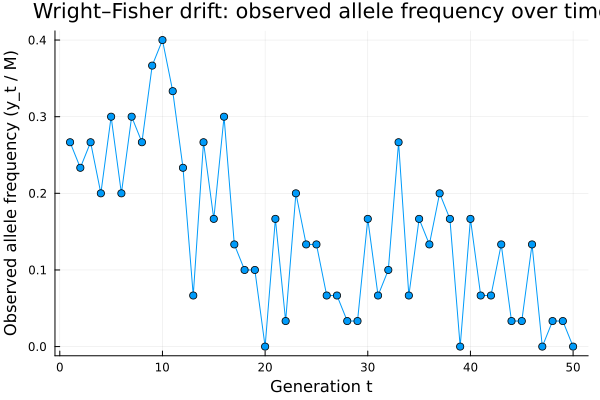

In [17]:
obs = get_retval(trace)
T = length(obs)

# Plot observed sample allele frequency over time
freq = obs ./ M

plot(
    1:T,
    freq,
    xlabel = "Generation t",
    ylabel = "Observed allele frequency (y_t / M)",
    title = "Wright–Fisher drift: observed allele frequency over time",
    legend = false,
    marker = :circle
)
